# Simple CNN with PyTorch

In this notebook, I will show you how to create a simple Convolutional Neural Network (CNN) with PyTorch.

- Dataset: [Cat and Dog](https://www.kaggle.com/datasets/tongpython/cat-and-dog)

# Download Dataset

Download Cat Dog dataset from [One Drive](https://ncku365-my.sharepoint.com/:u:/g/personal/nm6121030_ncku_edu_tw/EbTwo26N_lZOgDCca7v03YwBH-qgc2hpg3hWsHZ_yzgZWQ?e=PseGN4) and extract it to the current directory.

In [1]:
import os

if os.path.exists("cat_dog_kaggle"):
    print('Dataset already downloaded and extracted')
else:
    !bash download_dataset.sh

Dataset already downloaded and extracted


# Download the package

In [2]:
%pip -q install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Visualize the data

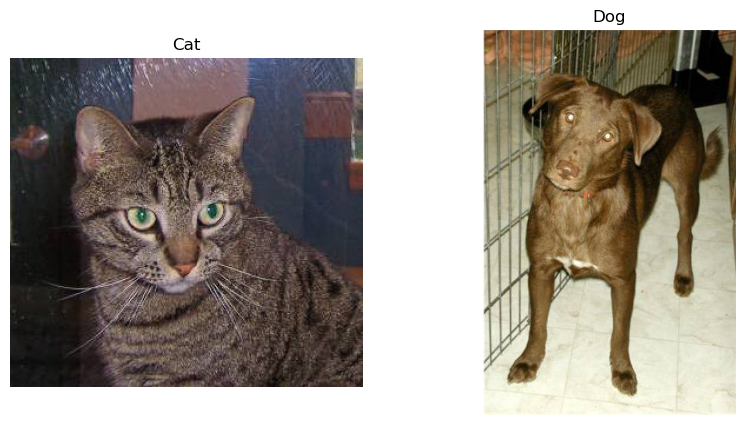

In [2]:
import matplotlib.pyplot as plt
import PIL

cat_img_path = './cat_dog_kaggle/training_set/cats/cat.1.jpg'
dog_img_path = './cat_dog_kaggle/training_set/dogs/dog.1.jpg'

cat_img = PIL.Image.open(cat_img_path)
dog_img = PIL.Image.open(dog_img_path)

plt.figure(figsize=(10, 5))
# Cat
plt.subplot(1, 2, 1)
plt.imshow(cat_img)
plt.title('Cat')
plt.axis('off')
# Dog
plt.subplot(1, 2, 2)
plt.imshow(dog_img)
plt.title('Dog')
plt.axis('off')
plt.show()

# Create Dataset and DataLoader

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
train_dataset = datasets.ImageFolder(root='cat_dog_kaggle/training_set', transform=transform)
test_dataset = datasets.ImageFolder(root='cat_dog_kaggle/test_set', transform=transform)

In [6]:
print(f"Training set:")
print(f"Number of images: {len(train_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")
# show the len of each class
print(f"Dataset distribution:")
print(f"{train_dataset.classes[0]}: {train_dataset.targets.count(0)}")
print(f"{train_dataset.classes[1]}: {train_dataset.targets.count(1)}")

print("="*20)

print(f"Test set:")
print(f"Number of images: {len(test_dataset)}")
print(f"Number of classes: {len(test_dataset.classes)}")
print(f"Classes: {test_dataset.classes}")
# show the len of each class
print(f"Dataset distribution:")
print(f"{test_dataset.classes[0]}: {test_dataset.targets.count(0)}")
print(f"{test_dataset.classes[1]}: {test_dataset.targets.count(1)}")

Training set:
Number of images: 8005
Number of classes: 2
Classes: ['cats', 'dogs']
Dataset distribution:
cats: 4000
dogs: 4005
Test set:
Number of images: 2023
Number of classes: 2
Classes: ['cats', 'dogs']
Dataset distribution:
cats: 1011
dogs: 1012


In [7]:
# split the train dataset into 80% train and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
# split
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")    # test set remains the same

Train dataset size: 6404
Validation dataset size: 1601
Test dataset size: 2023


In [8]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

# A 3-layer CNN

In [9]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*28*28, 512)
        self.fc2 = nn.Linear(512, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 224x224x3 -> 112x112x32
        x = self.pool(F.relu(self.conv2(x)))    # 112x112x32 -> 56x56x64
        x = self.pool(F.relu(self.conv3(x)))    # 56x56x64 -> 28x28x128
        x = x.view(-1, 128*28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# create model
model = CNN().to(device)

In [12]:
# show the model architecture
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Linear-7                  [-1, 512]      51,380,736
            Linear-8                    [-1, 2]           1,026
Total params: 51,475,010
Trainable params: 51,475,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 26.80
Params size (MB): 196.36
Estimated Total Size (MB): 223.74
----------------------------------------------------------------


# Hyperparameters

In [16]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 30

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and Validate

In [17]:
# record the training and validation accuracy & loss
train_accuracy, train_loss = [], []
val_accuracy, val_loss = [], []

In [18]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch+1}/{num_epochs}')
    for idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        # accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy.append(100 * correct / total)
    train_loss.append(running_loss / total)

    print(f'Training Loss: {train_loss[-1]:.4f}, Accuracy: {train_accuracy[-1]:.2f}%')
    
    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            # accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)
    val_loss.append(running_loss / total)

    print(f'Validation Loss: {val_loss[-1]:.4f}, Accuracy: {val_accuracy[-1]:.2f}%')

Epoch 1/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0045, Accuracy: 71.56%


Validation Loss: 0.0050, Accuracy: 66.52%
Epoch 2/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0039, Accuracy: 75.75%


Validation Loss: 0.0045, Accuracy: 70.27%
Epoch 3/30


100%|██████████| 51/51 [00:28<00:00,  1.79it/s]

Training Loss: 0.0034, Accuracy: 79.93%


Validation Loss: 0.0048, Accuracy: 70.14%
Epoch 4/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0027, Accuracy: 84.92%


Validation Loss: 0.0057, Accuracy: 68.39%
Epoch 5/30


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]

Training Loss: 0.0018, Accuracy: 90.85%


Validation Loss: 0.0067, Accuracy: 71.08%
Epoch 6/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0012, Accuracy: 94.13%


Validation Loss: 0.0076, Accuracy: 73.20%
Epoch 7/30


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]

Training Loss: 0.0005, Accuracy: 98.00%


Validation Loss: 0.0097, Accuracy: 72.64%
Epoch 8/30


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]

Training Loss: 0.0002, Accuracy: 99.11%


Validation Loss: 0.0110, Accuracy: 71.58%
Epoch 9/30


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]

Training Loss: 0.0001, Accuracy: 99.67%


Validation Loss: 0.0135, Accuracy: 71.27%
Epoch 10/30


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]

Training Loss: 0.0001, Accuracy: 99.83%


Validation Loss: 0.0137, Accuracy: 71.89%
Epoch 11/30


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]

Training Loss: 0.0001, Accuracy: 99.77%


Validation Loss: 0.0190, Accuracy: 68.52%
Epoch 12/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0002, Accuracy: 99.31%


Validation Loss: 0.0137, Accuracy: 72.33%
Epoch 13/30


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]

Training Loss: 0.0001, Accuracy: 99.84%


Validation Loss: 0.0164, Accuracy: 71.89%
Epoch 14/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0001, Accuracy: 99.47%


Validation Loss: 0.0144, Accuracy: 70.58%
Epoch 15/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0001, Accuracy: 99.81%


Validation Loss: 0.0170, Accuracy: 71.58%
Epoch 16/30


100%|██████████| 51/51 [00:28<00:00,  1.79it/s]

Training Loss: 0.0000, Accuracy: 99.94%


Validation Loss: 0.0158, Accuracy: 70.71%
Epoch 17/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0000, Accuracy: 99.98%


Validation Loss: 0.0181, Accuracy: 70.89%
Epoch 18/30


100%|██████████| 51/51 [00:29<00:00,  1.76it/s]

Training Loss: 0.0002, Accuracy: 99.28%


Validation Loss: 0.0140, Accuracy: 68.14%
Epoch 19/30


100%|██████████| 51/51 [00:28<00:00,  1.79it/s]

Training Loss: 0.0002, Accuracy: 99.16%


Validation Loss: 0.0154, Accuracy: 69.27%
Epoch 20/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0001, Accuracy: 99.52%


Validation Loss: 0.0166, Accuracy: 69.64%
Epoch 21/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0000, Accuracy: 99.83%


Validation Loss: 0.0176, Accuracy: 70.77%
Epoch 22/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0001, Accuracy: 99.77%


Validation Loss: 0.0183, Accuracy: 71.21%
Epoch 23/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0000, Accuracy: 99.95%


Validation Loss: 0.0187, Accuracy: 71.21%
Epoch 24/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0000, Accuracy: 99.95%


Validation Loss: 0.0189, Accuracy: 71.71%
Epoch 25/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0000, Accuracy: 99.92%


Validation Loss: 0.0178, Accuracy: 71.83%
Epoch 26/30


100%|██████████| 51/51 [00:28<00:00,  1.79it/s]

Training Loss: 0.0000, Accuracy: 99.94%


Validation Loss: 0.0194, Accuracy: 70.58%
Epoch 27/30


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]

Training Loss: 0.0000, Accuracy: 100.00%


Validation Loss: 0.0191, Accuracy: 71.33%
Epoch 28/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0000, Accuracy: 100.00%


Validation Loss: 0.0197, Accuracy: 71.39%
Epoch 29/30


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]

Training Loss: 0.0000, Accuracy: 100.00%


Validation Loss: 0.0200, Accuracy: 71.64%
Epoch 30/30


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]

Training Loss: 0.0000, Accuracy: 100.00%


Validation Loss: 0.0203, Accuracy: 71.71%


# Visualize the results

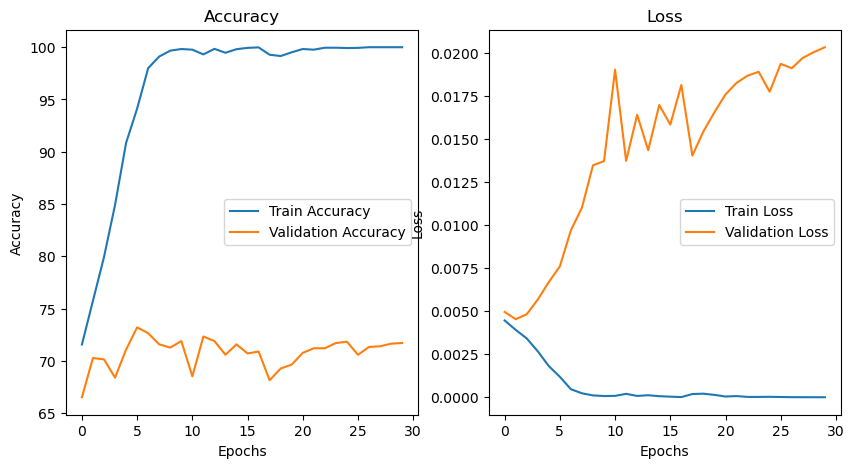

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# plot the training and validation accuracy and loss
plt.figure(figsize=(10, 5))
# accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# show
plt.show()

# Test

In [20]:
test_accuracy = 0
total = 0

model.eval()
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # accuracy
        total += labels.size(0)
        test_accuracy += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * test_accuracy / total:.2f}%')

Test Accuracy: 71.48%


# Next step

try transfer learning with pre-trained models.